In [1]:
import warnings
import logging
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Suppress frequent warning categories
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# SciKit-Learn and StatsModels convergence warnings (if any models emit them)
try:
    from sklearn.exceptions import ConvergenceWarning as SKConvergenceWarning
    warnings.filterwarnings("ignore", category=SKConvergenceWarning)
except Exception:
    pass

try:
    from statsmodels.tools.sm_exceptions import ConvergenceWarning as SMConvergenceWarning
    warnings.filterwarnings("ignore", category=SMConvergenceWarning)
except Exception:
    pass

# Lower logging levels for noisy libraries
logging.getLogger().setLevel(logging.ERROR)
for name in ["matplotlib", "urllib3", "numexpr", "PIL", "sklearn", "statsmodels"]:
    logging.getLogger(name).setLevel(logging.ERROR)

print("Warnings silenced; logging set to ERROR.")

Warnings silenced; logging set to ERROR.


# Loading data

Loading data from csv, which is downloaded from (https://www.kaggle.com/datasets/jaorcovre/galton-height-data)

In [2]:
df_raw = pd.read_csv('galton-stata11.csv', sep='\t')

df_raw

,family,father,mother,gender,height,kids,male,female
0,1,78.5,67.0,M,73.2,4,1.0,0.0
1,1,78.5,67.0,F,69.2,4,0.0,1.0
2,1,78.5,67.0,F,69.0,4,0.0,1.0
3,1,78.5,67.0,F,69.0,4,0.0,1.0
4,2,75.5,66.5,M,73.5,4,1.0,0.0
...,...,...,...,...,...,...,...,...
893,136A,68.5,65.0,M,68.5,8,1.0,0.0
894,136A,68.5,65.0,M,67.7,8,1.0,0.0
895,136A,68.5,65.0,F,64.0,8,0.0,1.0
896,136A,68.5,65.0,F,63.5,8,0.0,1.0


# Data preprocessing

Process data so that it align with the data introduced in the assignment pdf

In [3]:
df = df_raw.copy()
df['midparentHeight'] = (df['father'] + 1.08*df['mother']) / 2

df.head()

,family,father,mother,gender,height,kids,male,female,midparentHeight
0,1,78.5,67.0,M,73.2,4,1.0,0.0,75.43
1,1,78.5,67.0,F,69.2,4,0.0,1.0,75.43
2,1,78.5,67.0,F,69.0,4,0.0,1.0,75.43
3,1,78.5,67.0,F,69.0,4,0.0,1.0,75.43
4,2,75.5,66.5,M,73.5,4,1.0,0.0,73.66


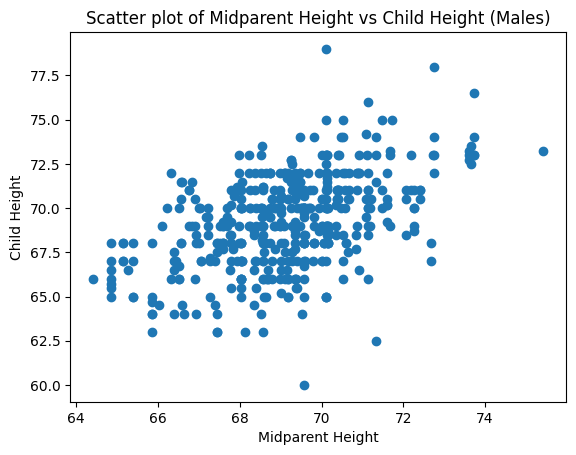

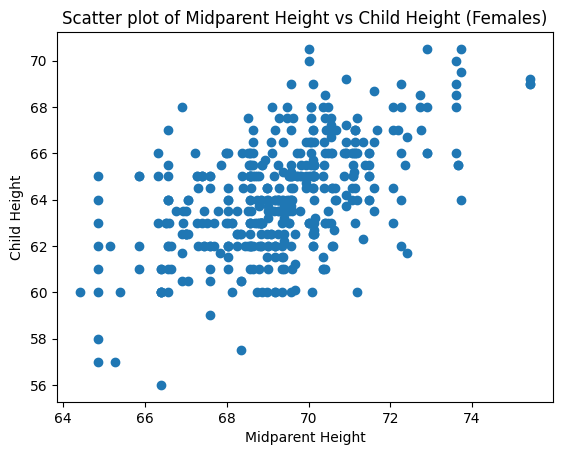

In [4]:
males = df[df['gender']=='M']
females = df[df['gender']=='F']

plt.scatter(males['midparentHeight'], males['height'])
plt.xlabel('Midparent Height')
plt.ylabel('Child Height')
plt.title('Scatter plot of Midparent Height vs Child Height (Males)')
plt.show()

plt.scatter(females['midparentHeight'], females['height'])
plt.xlabel('Midparent Height')
plt.ylabel('Child Height')
plt.title('Scatter plot of Midparent Height vs Child Height (Females)')
plt.show()

# Experiment settings

Experiment procedure: 100 random splits with 200 held-out tests; report MSE and a boxplot; fixed seed for reproducibility.

In [5]:
nrep = 100
ntest = 200
n = len(df)

# Baseline linear regression

Method description:
- Target: child height (`height`)
- Features: categorical gender (`gender`) and midparent height (`(father + 1.08*mother)/2`)

Mean MSE: 4.682635519993236


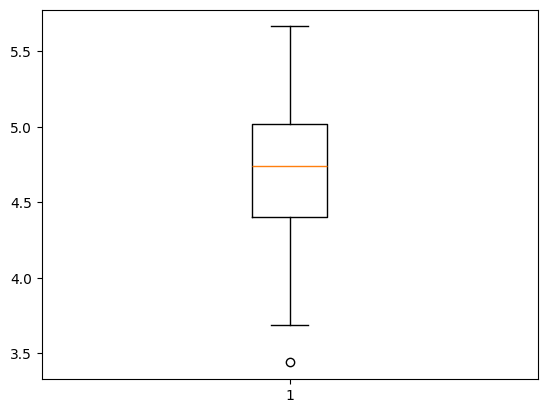

In [6]:
np.random.seed(1)

mse_list = []

all_idx = np.arange(n)
for i in range(nrep):
    train_idx = np.random.choice(all_idx, size=n-ntest, replace=False)
    test_idx = np.setdiff1d(all_idx, train_idx)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    formula = 'height ~ C(gender) + midparentHeight'
    model = smf.ols(formula, data=train_df).fit()

    pred = model.predict(test_df)

    mse = np.mean((test_df['height'].values - pred.values) ** 2)
    mse_list.append(mse)

print(f"Mean MSE: {np.mean(mse_list)}")

plt.boxplot(mse_list)
plt.show()

# My methods

This section documents each non-baseline approach with a short note placed immediately above the corresponding code cell.

Common setup
- Target: child height (`height`)
- Features: `father`, `mother`, `male`, `kids`


Notes
- Sex is encoded as $\text{male}\in\{0,1\}$; the intercept is the female baseline, $\beta_s$ is the male shift.

## Linear regression - OLS
- Model: for each child $i$, let $x_i = [1,\, \text{father}_i,\, \text{mother}_i,\, \text{male}_i,\, \text{kids}_i]^\top$ and $y_i = \text{height}_i$.
- Matrix form: $y = X\beta + \varepsilon$, $X \in \mathbb R^{n\times 5}$.

Estimation (OLS)
- $\hat\beta = \arg\min_{\beta} \lVert y - X\beta \rVert_2^2$. Normal equations: $(X^\top X)\hat\beta = X^\top y$.
- Prediction: $\hat y(x) = x^\top \hat\beta$. 

Mean MSE: 4.6558


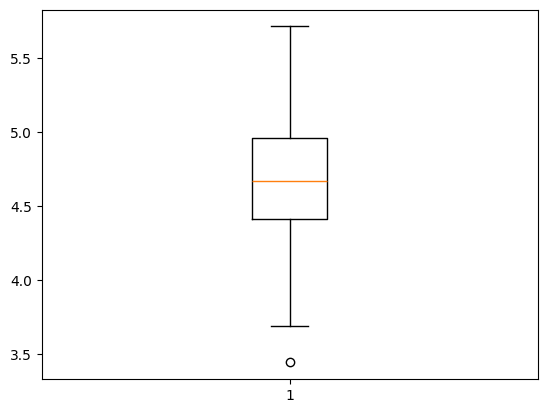

In [7]:
np.random.seed(1)

mse_list = []

all_idx = np.arange(n)
for i in range(nrep):
    train_idx = np.random.choice(all_idx, size=n-ntest, replace=False)
    test_idx = np.setdiff1d(all_idx, train_idx)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    X_train = train_df[['father', 'mother', 'male', 'kids']]
    y_train = train_df['height']
    X_test = test_df[['father', 'mother', 'male', 'kids']]
    y_test = test_df['height']
    
    model = LinearRegression().fit(X_train, y_train)
    pred = model.predict(X_test)

    mse = np.mean((test_df['height'].values - pred) ** 2)
    mse_list.append(mse)

print(f"Mean MSE: {np.mean(mse_list):.4f}")

plt.boxplot(mse_list)
plt.show()

## Ridge regression (L2)
Objective
- $\hat\beta_{\text{ridge}} = \arg\min_{\beta} \; \lVert y - X\beta \rVert_2^2 + \alpha \lVert \beta \rVert_2^2$, with $\alpha \ge 0$.

Closed form
- With centered $X$ and $y$, $\hat\beta_{\text{ridge}} = (X^\top X + \lambda I)^{-1} X^\top y$.

Mean MSE: 4.6553


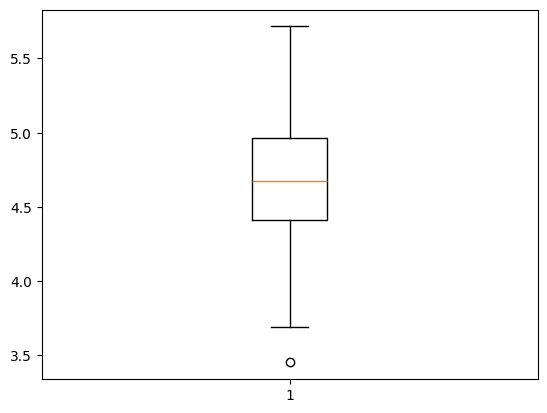

In [8]:
np.random.seed(1)

mse_list = []

all_idx = np.arange(n)
for i in range(nrep):
    train_idx = np.random.choice(all_idx, size=n-ntest, replace=False)
    test_idx = np.setdiff1d(all_idx, train_idx)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    X_train = train_df[['father', 'mother', 'male', 'kids']]
    y_train = train_df['height']
    X_test = test_df[['father', 'mother', 'male', 'kids']]
    y_test = test_df['height']
    
    model = Ridge().fit(X_train, y_train)
    pred = model.predict(X_test)

    mse = np.mean((test_df['height'].values - pred) ** 2)
    mse_list.append(mse)

print(f"Mean MSE: {np.mean(mse_list):.4f}")

plt.boxplot(mse_list)
plt.show()

## Lasso regression (L1)
Objective
- $\hat\beta_{\text{lasso}} = \arg\min_{\beta} \; \tfrac{1}{2n}\lVert y - X\beta \rVert_2^2 + \alpha \lVert \beta \rVert_1$.

Properties
- Promotes sparsity; some coefficients are exactly 0.

Mean MSE: 9.1096


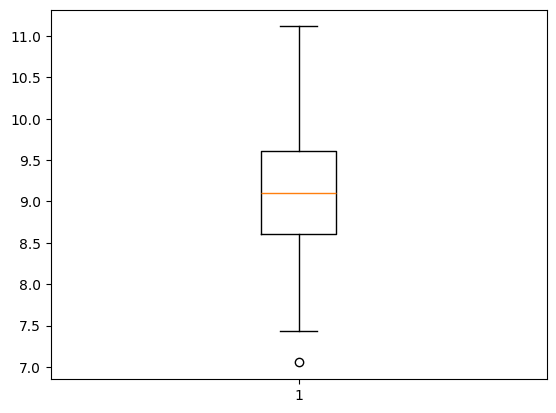

In [9]:
np.random.seed(1)

mse_list = []

all_idx = np.arange(n)
for i in range(nrep):
    train_idx = np.random.choice(all_idx, size=n-ntest, replace=False)
    test_idx = np.setdiff1d(all_idx, train_idx)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    X_train = train_df[['father', 'mother', 'male', 'kids']]
    y_train = train_df['height']
    X_test = test_df[['father', 'mother', 'male', 'kids']]
    y_test = test_df['height']
    
    model = Lasso().fit(X_train, y_train)
    pred = model.predict(X_test)

    mse = np.mean((test_df['height'].values - pred) ** 2)
    mse_list.append(mse)

print(f"Mean MSE: {np.mean(mse_list):.4f}")

plt.boxplot(mse_list)
plt.show()

## Multilayer Perceptron (MLP)
Architecture
- One hidden layer: $h = \phi(W_1 x + b_1)$, $\; \hat y(x) = W_2 h + b_2$. For depth $L$: $h^{(\ell)} = \phi^{(\ell)}(W_\ell h^{(\ell-1)} + b_\ell)$.

Training
- Minimize empirical risk (MSE) with L2 weight decay $\alpha$:
  $\mathcal L = \tfrac{1}{2n}\sum_i (y_i - \hat y(x_i))^2 + \tfrac{\alpha}{2} \sum_\ell \lVert W_\ell \rVert^2$.
- Optimize by Adam with backpropagation.

Mean MSE: 6.2153


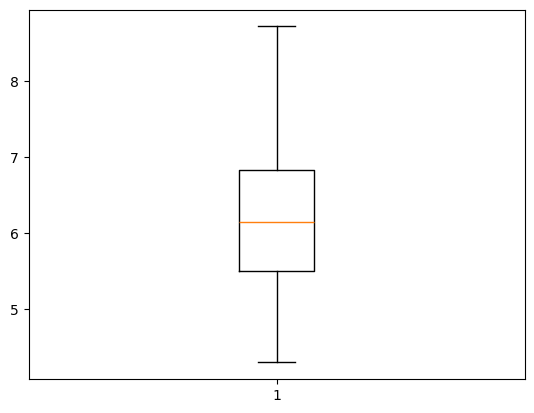

In [10]:
np.random.seed(1)

mse_list = []

all_idx = np.arange(n)
for i in range(nrep):
    train_idx = np.random.choice(all_idx, size=n-ntest, replace=False)
    test_idx = np.setdiff1d(all_idx, train_idx)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    X_train = train_df[['father', 'mother', 'male', 'kids']]
    y_train = train_df['height']
    X_test = test_df[['father', 'mother', 'male', 'kids']]
    y_test = test_df['height']

    model = MLPRegressor(solver='adam').fit(X_train, y_train)
    pred = model.predict(X_test)

    mse = np.mean((test_df['height'].values - pred) ** 2)
    mse_list.append(mse)

print(f"Mean MSE: {np.mean(mse_list):.4f}")

plt.boxplot(mse_list)
plt.show()


## Decision tree regressor
CART splitting
- Recursively partition by axis-aligned splits $x_j \le t$ to maximize squared-error reduction.
- At node $S$, choose $(j,t)$ to minimize impurity: $\Delta = \operatorname{SSE}(S) - [\operatorname{SSE}(S_L) + \operatorname{SSE}(S_R)]$, where
  $\operatorname{SSE}(S) = \sum_{i\in S} (y_i - \bar y_S)^2$ and $\bar y_S = |S|^{-1}\sum_{i\in S} y_i$.

Leaves and prediction
- Stop via constraints (min\_samples\_leaf, max\_depth, etc.). Predict with the leaf mean $\bar y_{\text{leaf}}$.

Mean MSE: 6.1232


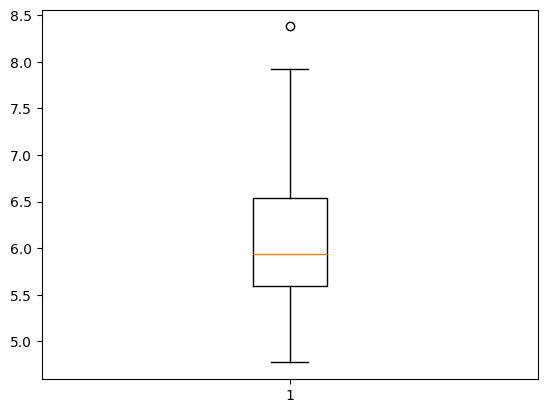

In [11]:
np.random.seed(1)

mse_list = []

all_idx = np.arange(n)
for i in range(nrep):
    train_idx = np.random.choice(all_idx, size=n-ntest, replace=False)
    test_idx = np.setdiff1d(all_idx, train_idx)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    X_train = train_df[['father', 'mother', 'male', 'kids']]
    y_train = train_df['height']
    X_test = test_df[['father', 'mother', 'male', 'kids']]
    y_test = test_df['height']
    
    model = DecisionTreeRegressor().fit(X_train, y_train)
    pred = model.predict(X_test)

    mse = np.mean((test_df['height'].values - pred) ** 2)
    mse_list.append(mse)

print(f"Mean MSE: {np.mean(mse_list):.4f}")

plt.boxplot(mse_list)
plt.show()

## LightGBM
Overview
- Gradient Boosting Decision Trees optimized with histogram-based splits and leaf-wise (best-first) tree growth for speed and accuracy.

Model
- Additive form:  $\hat y(x) = \sum_{t=1}^{T} f_t(x)$, where each $f_t$ is a shallow regression tree.
- At boosting step $t$: fit $f_t$ to current residuals/negative gradients of the loss (here MSE).

Mean MSE: 4.9256


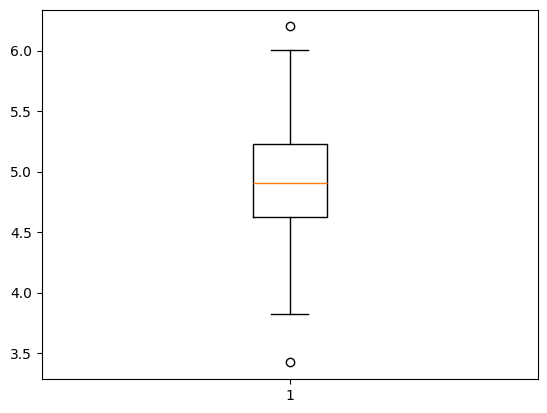

In [12]:
np.random.seed(1)

mse_list = []

all_idx = np.arange(n)
for _ in range(nrep):
    train_idx = np.random.choice(all_idx, size=n-ntest, replace=False)
    test_idx = np.setdiff1d(all_idx, train_idx)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    X_train = train_df[['father', 'mother', 'male', 'kids']]
    y_train = train_df['height']
    X_test = test_df[['father', 'mother', 'male', 'kids']]
    y_test = test_df['height']

    model = lgb.LGBMRegressor(
        objective='regression',
        random_state=1,
        verbosity=-1, 
    )
    model.fit(X_train, y_train)

    pred = model.predict(X_test)

    mse = np.mean((y_test.values - pred) ** 2)
    mse_list.append(mse)

print(f"Mean MSE: {np.mean(mse_list):.4f}")

plt.boxplot(mse_list)
plt.show()

## Random forest regressor
Ensemble construction
- For $b=1,\dots,B$: draw a bootstrap sample and grow an unpruned tree using $m_{\text{try}}$ random features at each split.

Predictor
- Average trees: $\hat y_{\text{RF}}(x) = \tfrac{1}{B} \sum_{b=1}^B T_b(x)$.

Mean MSE: 5.2200


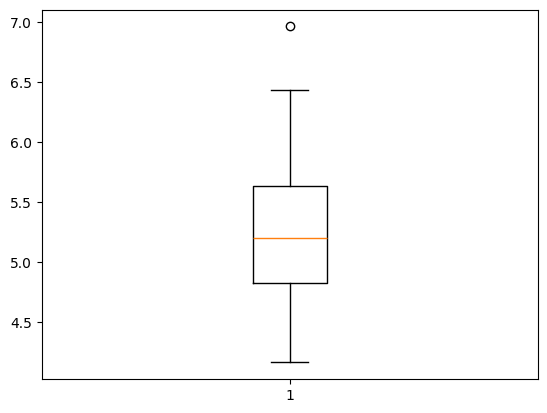

In [13]:
np.random.seed(1)

mse_list = []

all_idx = np.arange(n)
for i in range(nrep):
    train_idx = np.random.choice(all_idx, size=n-ntest, replace=False)
    test_idx = np.setdiff1d(all_idx, train_idx)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    X_train = train_df[['father', 'mother', 'male', 'kids']]
    y_train = train_df['height']
    X_test = test_df[['father', 'mother', 'male', 'kids']]
    y_test = test_df['height']
    
    model = RandomForestRegressor().fit(X_train, y_train)
    pred = model.predict(X_test)

    mse = np.mean((test_df['height'].values - pred) ** 2)
    mse_list.append(mse)

print(f"Mean MSE: {np.mean(mse_list):.4f}")

plt.boxplot(mse_list)
plt.show()

## k-Nearest Neighbors (KNN)
Estimator
- For query $x$, find $\mathcal N_k(x)$: indices of the $k$ nearest training points under distance $d$ (Euclidean by default).
- Predict by local average: $\hat y(x) = \tfrac{1}{k} \sum_{i\in \mathcal N_k(x)} y_i$ (or distance-weighted variants).

Mean MSE: 8.2872


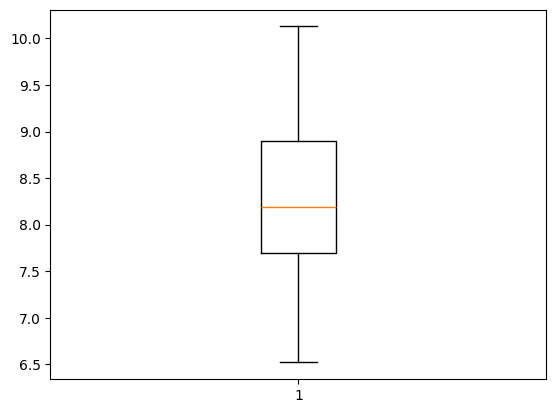

In [14]:
np.random.seed(1)

mse_list = []

all_idx = np.arange(n)
for i in range(nrep):
    train_idx = np.random.choice(all_idx, size=n-ntest, replace=False)
    test_idx = np.setdiff1d(all_idx, train_idx)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    X_train = train_df[['father', 'mother', 'male', 'kids']]
    y_train = train_df['height']
    X_test = test_df[['father', 'mother', 'male', 'kids']]
    y_test = test_df['height']
    
    model = KNeighborsRegressor().fit(X_train, y_train)
    pred = model.predict(X_test)

    mse = np.mean((test_df['height'].values - pred) ** 2)
    mse_list.append(mse)

print(f"Mean MSE: {np.mean(mse_list):.4f}")

plt.boxplot(mse_list)
plt.show()

## Support Vector Regression (SVR)
Primal
- Minimize $\tfrac{1}{2}\lVert w \rVert_2^2 + C \sum_i (\xi_i + \xi_i^*)$ subject to $\varepsilon$-insensitive constraints:
  $y_i - (w^\top \phi(x_i) + b) \le \varepsilon + \xi_i$, $\;(w^\top \phi(x_i) + b) - y_i \le \varepsilon + \xi_i^*$, $\;\xi_i,\xi_i^* \ge 0$.

Dual/kernel view
- Use kernel RBF: $K(x,x') = \exp(-\gamma\lVert x-x' \rVert_2^2)$.
- Predictor: $\hat y(x) = \sum_i (\alpha_i - \alpha_i^*)\, K(x_i, x) + b$, where most $\alpha_i, \alpha_i^* = 0$.


Mean MSE: 11.7452


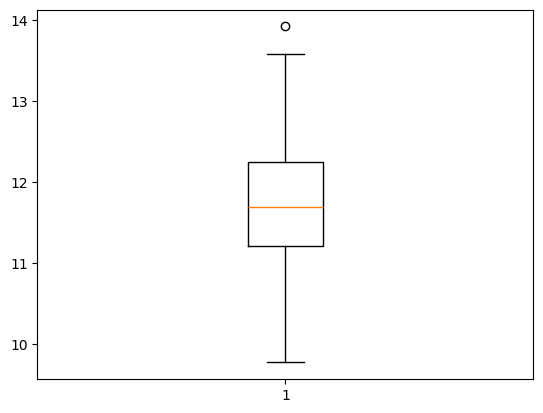

In [15]:
np.random.seed(1)

mse_list = []

all_idx = np.arange(n)
for i in range(nrep):
    train_idx = np.random.choice(all_idx, size=n-ntest, replace=False)
    test_idx = np.setdiff1d(all_idx, train_idx)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    X_train = train_df[['father', 'mother', 'male', 'kids']]
    y_train = train_df['height']
    X_test = test_df[['father', 'mother', 'male', 'kids']]
    y_test = test_df['height']
    
    model = SVR(kernel='rbf').fit(X_train, y_train)
    pred = model.predict(X_test)

    mse = np.mean((test_df['height'].values - pred) ** 2)
    mse_list.append(mse)

print(f"Mean MSE: {np.mean(mse_list):.4f}")

plt.boxplot(mse_list)
plt.show()

## Outlier filtering + Refit OLS
Procedure
- First fit an OLS on all training data with all features.
- Compute residuals on the training set and flag outliers by an absolute-residual threshold.
- Here we use a fixed threshold of `1.645 * σ_y` (roughly the central 90% under normality), keeping points with |residual| ≤ threshold.
- Refit OLS on the retained inliers and evaluate on the test set.

Rationale
- Robustness: removing extreme residuals can reduce the influence of mislabeled or atypical points on the linear fit.

Mean MSE: 4.6563


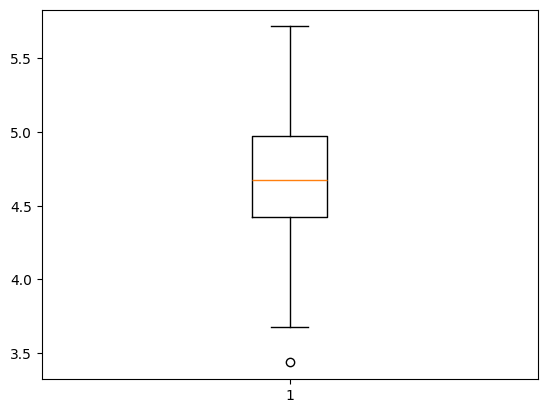

In [16]:
np.random.seed(1)

mse_list = []


all_idx = np.arange(n)
for i in range(nrep):
    train_idx = np.random.choice(all_idx, size=n-ntest, replace=False)
    test_idx = np.setdiff1d(all_idx, train_idx)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    X_train = train_df[['father', 'mother', 'male', 'kids']]
    y_train = train_df['height']
    X_test = test_df[['father', 'mother', 'male', 'kids']]
    y_test = test_df['height']
    
    model = LinearRegression().fit(X_train, y_train)
    pred_train = model.predict(X_train)
    residuals = y_train - pred_train

    threshold = 1.645 * y_train.std()
    mask = np.abs(residuals) <= threshold
    X_train = X_train.loc[mask]
    y_train = y_train.loc[mask]

    model = LinearRegression().fit(X_train, y_train)
    pred = model.predict(X_test)

    mse = np.mean((test_df['height'].values - pred) ** 2)
    mse_list.append(mse)

print(f"Mean MSE: {np.mean(mse_list):.4f}")

plt.boxplot(mse_list)
plt.show()

## Model Averaging
Setup
- Train multiple base regressors on the same features `[father, mother, male, kids]`:
  - LinearRegression 
  - MLPRegressor
  - DecisionTreeRegressor
- For each split, predict with each model and take the simple average of predictions.

Mean MSE: 4.6421


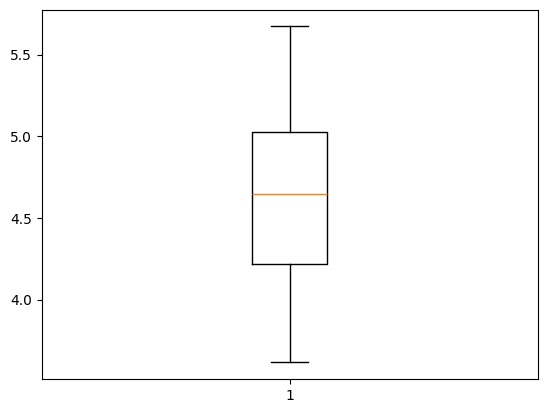

In [17]:
np.random.seed(1)

model_list = [
    LinearRegression(),
    MLPRegressor(solver='adam'), 
    DecisionTreeRegressor(),
]

mse_list = []

all_idx = np.arange(n)
for i in range(nrep):
    train_idx = np.random.choice(all_idx, size=n-ntest, replace=False)
    test_idx = np.setdiff1d(all_idx, train_idx)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    X_train = train_df[['father', 'mother', 'male', 'kids']]
    y_train = train_df['height']
    X_test = test_df[['father', 'mother', 'male', 'kids']]
    y_test = test_df['height']

    preds = np.zeros((ntest, len(model_list)))
    for m, model in enumerate(model_list):
        model.fit(X_train, y_train)
        preds[:, m] = model.predict(X_test)

    pred = preds.mean(axis=1)

    mse = np.mean((test_df['height'].values - pred) ** 2)
    mse_list.append(mse)

print(f"Mean MSE: {np.mean(mse_list):.4f}")

plt.boxplot(mse_list)
plt.show()

# Discussion

The model averaging method performs the best, but the improvement is not very significant (MSE: 4.68 -> 4.64).

I believe most of the improvements come from the modification of the models' input features. Instead of using `gender` and `midparentheight`, I am using `gender`, the raw mom's height `mom`, the raw dad's height `dad`, and number of kids of the family `kids`. 

It is very surprising to see that it is very difficult to beat the baseline linear regression, which is one of the simplest model. Even my favorite model LightGBM fails to beat the baseline linear regression. I think there are two reason that explain why the linear regression performs so well on this dataset:

1. The relation between $X$ and $y$ is indeed linear. The plot in the first few cell has clearly shown this linear relationship. 
   
2. The $X$ and $y$ is not a one-to-one relation, instead it is a one-to-many relation. For a given $X$ (e.g., the same parents’ heights), different children can have different heights due to unobserved factors. That means $Var(y|X) > 0$ and there are repeated or near-duplicate $X$ values mapping to different $y$. As a result, we cannot even use a complex model to overfit the data to get a lower MSE. 